import all relevant modules

In [159]:

from Bio import SeqIO, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
import Bio.Align
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
import os
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from pymsaviz import MsaViz
import time

Setup the directory

In [160]:
#set current directory to my_project

#complete these variables with the input files directory
dog_breeds = r"C:\Users\User\Downloads\Coursework-main\Coursework-main\my_project\data\dog_breeds.fa"
mystery_breed = r"C:\Users\User\Downloads\Coursework-main\Coursework-main\my_project\data\mystery.fa"
output = r"C:\Users\User\Downloads\Coursework-main\Coursework-main\my_project\results"
ind_breeds = r"C:\Users\User\Downloads\Coursework-main\Coursework-main\my_project\results\individual_breed_sequences"


Set up basic functions 

In [161]:
def read_fasta(filename):
    """function which reads a fasta file and returns a list of sequiences found in the file"""
    sequences = []
    for record in SeqIO.parse(filename, "fasta"): 
        sequences.append(record.seq)
    return(sequences)

def create_output(content, filename:str, filetype:str):
        """creates a file in the results folder with the content provided in the the correct format """
        #create an empty file by openening it in a write format 
        filepath = f"{output}/{filename}"
        with open(filename, "w") as f:
                if filetype == "fasta":
                        SeqIO.write(content, filepath, filetype) 
                elif filetype == "txt":
                        f.write(content)
def simple_alignment(seq1,seq2):
    """align two sequences given as parameters and return alignment score and alignment"""
    aligner = Bio.Align.PairwiseAligner() 
    score = aligner.score(seq1, seq2)
    alignment = aligner.align(seq1, seq2)
    return score, alignment



Set up the Breed class 

In [162]:
class Breed():
    """This class stores information about every breed and their sequence"""
    #create a list to store all instances of the class
    all_instances = []
    #define an init function which stores the sequence as a sequence object, the breed as a string and the fasta format of the sequence
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        #store all initialised instances in the defined list
        Breed.all_instances.append(self) 
#open the fasta file and save the sequence breed and sequence name in a Breed Class to be accessed later
def initialise_Breed(filename = dog_breeds, format = "fasta"):
    #parse through the dog_breeds file
    for record in SeqIO.parse(filename, format):
        #get the description of each sequence to find out what breed it is 
        #split the description on "[" as these are used to separate each descriptor
        for key in list(record.description.split("[")): 
            #if the keyword breed is in the description but the keyword "isolate" is not in thr description it will define the dog breed 
            if "breed" in key and "isolate" not in key:
                #each sequence in filename gets assigned a name based on the breed identified in the desciption
                breed_name = (key[6:-2]).upper()
                #intialises an object of class Breed which contains the sequence, breed name and the full record 
                record.name = Breed(record.seq, breed_name, record)
#call the function
initialise_Breed()

Create consensus files for each breed

In [163]:
def unique_breeds():
    """set up a list that contains all unique breed names in a list"""
    all_breeds = set()
    #itterate through all instances in Breed class
    for key in Breed.all_instances:
        #access and add every breed to the all_breeds set
        all_breeds.add(key.breed)
    return all_breeds
    

def breed_sequences(directory = ind_breeds):
    """write a fasta file containing all sequences that belong to the same breed """
    for breed in unique_breeds():
        #creates a temporary variable corresponding to each individual dog breed 
        temp = breed
        #create a directory for filename
        filename = f"{directory}/{breed}.fa"
        #itterate throough all instances of the class Breed
        sequences = []
        for key in Breed.all_instances: 
            #check if the breedd is the same as the current breed in the loop stored in the temp variable 
            if key.breed == temp:
                sequences.append(key.fasta)
                #adds the sequences to a file with the name of the breed as a filename
        SeqIO.write(sequences, filename, "fasta") 

breed_sequences()
def consensus_seq(filename):
    """Function that takes in a file containing a number of sequences and returns a consensus sequence"""
    os.chdir(ind_breeds) 
    #align all the sequences in each file
    alignments = AlignIO.parse(filename, "fasta") 
    #assign filename to varible recordname which will be used to create a name for this record 
    recordname = f"{filename}"
    for alignment in alignments: 
        #get summary info of each alignment to create a consensus 
        summary = SummaryInfo(alignment) 
        #create a consensus of each alignment 
        consensus = summary.dumb_consensus() 
        #create a fasta format sequence using the consensus sequence and recordname
        seq_record = SeqRecord(Seq(consensus), id=recordname) 
        #add each consensus seq to a list 
    return seq_record


def consensus_file(directory=output):
    """create a consensus sequence for each breed and store it in a list"""
    #create a list to store the sequences
    consensus_sequences = [] 
    for file in unique_breeds():
        #run the consensus_seq function to get the consensus file of each breed in the consensus list 
        consensus_sequences.append(consensus_seq(file))
    return consensus_sequences
        
def add_mystery_to_consensus():
    consensus_sequences = list(consensus_file())
    unknown_sequence = (read_fasta(mystery_breed))[0]
    #add mystery sequence to the consensus file list 
    consensus_sequences.append(SeqRecord(unknown_sequence, id="mystery_sequence"))
    return consensus_sequences

#store consensus sequences in a results folder in a file called consensus_sequences
create_output(consensus_file(), "consensus_sequences", "fasta" )
#create output with the mystery sequence
create_output(add_mystery_to_consensus(), "consensus_sequences_with_mystery", "fasta" )


Create a class to store consensus sequences 

In [164]:
#get consensus sequences
consensus_file = f"{output}/consensus_sequences"
consensus_sequences = read_fasta(consensus_file)
#get mystery sequences
mystery_sequence = read_fasta(mystery_breed)

class Breed_consensus():
    """This class stores information about every breed and their sequence"""
    #create a list to store all instances of the class
    all_instances = []
    #define an init function which stores the sequence as a sequence object, the breed as a string and the fasta format of the sequence
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        #store all initialised instances in the defined list
        Breed_consensus.all_instances.append(self) 
#open the fasta file and save the sequence breed and sequence name in a Breed Class to be accessed later
def initialise_Breed_consensus(filename = consensus_file, format = "fasta"):
    #parse through the dog_breeds file
    for record in SeqIO.parse(filename, format):
            #intialises an object of class Breed which contains the sequence, breed name and the full record 
            breed_name = record.description.replace("<unknown description>", "")
            record.id = Breed_consensus(record.seq, breed_name, record)
#call the function
initialise_Breed_consensus()


Find the top alignment and store it in a file (this function is the one which takes the longest)

In [165]:
#align_consensus sequences with the mystery sequence
def align_consensus(sequences_list=consensus_sequences, unknown_sequence = mystery_sequence[0]):
    """uses the simple alignment function to cretae an alignment between unknown sequence and database. Returns the score and alignment of the top scoring alignment."""
    #set up a list for all alignment score 
    current_best = 0
    current_best_alignment = 0
    current_sequence = 0
    top_breed = ""
    #itterate through the sequences in the database
    for sequence in sequences_list:
        #determine the score of each alignment
        score = (simple_alignment(sequence, unknown_sequence)[0])
        if score > current_best:
            current_best = score
            alignment = (simple_alignment(sequence, unknown_sequence)[1])
            current_sequence = sequence
            current_best_alignment = alignment
    for key in Breed_consensus.all_instances:
        if key.sequence == current_sequence:
            top_breed = key.breed
    print(current_best, current_best_alignment, top_breed)
    return current_best, current_best_alignment, top_breed


top_alignment_details = align_consensus()
top_alignment = top_alignment_details[1][0]

#create a directory for the top alignment file 
filename = f"{output}/top_alignment_output"  
#create a file to store the top scoring alignment as clustal file 
with open(filename, "w"):
        Bio.Align.write(top_alignment, filename, "clustal")

16705.0 <Bio.Align.PairwiseAlignments object at 0x000001E014849190> ENGLISH SPRINGER SPANIEL 


Calculate percentage similarity of the top scoring sequence 

In [166]:
def percentage_similarity(aln):
    """Given a pairwise alignment calculates the percentage similarity between the two sequences"""
    #create a varieble to store the instances where columns are identical
    identical_columns = float()
    #itterate through every column of the alignment
    for a in range(len(aln[0])): 
        #check if first and second sequence is the same at point a, a describing the column 
        if aln[0,a] == aln[1,a]: 
            #if base at position a is the same in both sequences add 1 to the amount of identical columns 
            identical_columns += 1
    #calculate the percentage based on the identical columns number and the length of the alignment 
    percentage = 100 * identical_columns / float(len(aln[0])) 
    #return percentage to 3dp
    return  round(percentage,3) 

#calculate percentage similarity of the top scoring sequence 
top_percentage = percentage_similarity(top_alignment)

Save the results to a text file containing an explanation of the values generated 
-create a pymasviz grpah to better visualise the alignment, stored in results 

In [167]:
#get results aka the breed, its sequence and percentage similarity 
results = "The breed most similar to the mystery DNA file is the", top_alignment_details[2], "its percent identity is", top_percentage, "%" ,"the alignment of the mystery dog breed and", top_alignment_details[2], "is displayed here\n", top_alignment

#create a string representing thr results that can be written to the results file 
results_str = str()
for key in results:
    results_str += str(key) 

#create a directory and filename for the details of the top alignment
filename2 = f"{output}/top_alignment_details"  
#create a file to store details about the  top alignment as a txt file 
with open(filename2, "w") as file:
        file.write(results_str)

#create a graph for each 100 bases long sequence alignment figure 

read_alignment = AlignIO.read(f"{output}/top_alignment_output", "clustal")  

l = len(top_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100)
mv.savefig(f"{output}/top_alignment_image")

Create a phylogenic tree describing the relationship between the breeds 
- organise this into functions 

[SeqRecord(seq=Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), id='PORTUGUESE WARREN DOG, SMALL SIZE, WEIRED HAIR', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), id='CANIS PANTHER', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), id='CASTRO LABOREIRO WATCHDOG', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), id='BLACK RETRIEVER', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), id='PORTUGUESE SHEEPDOG', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGAT

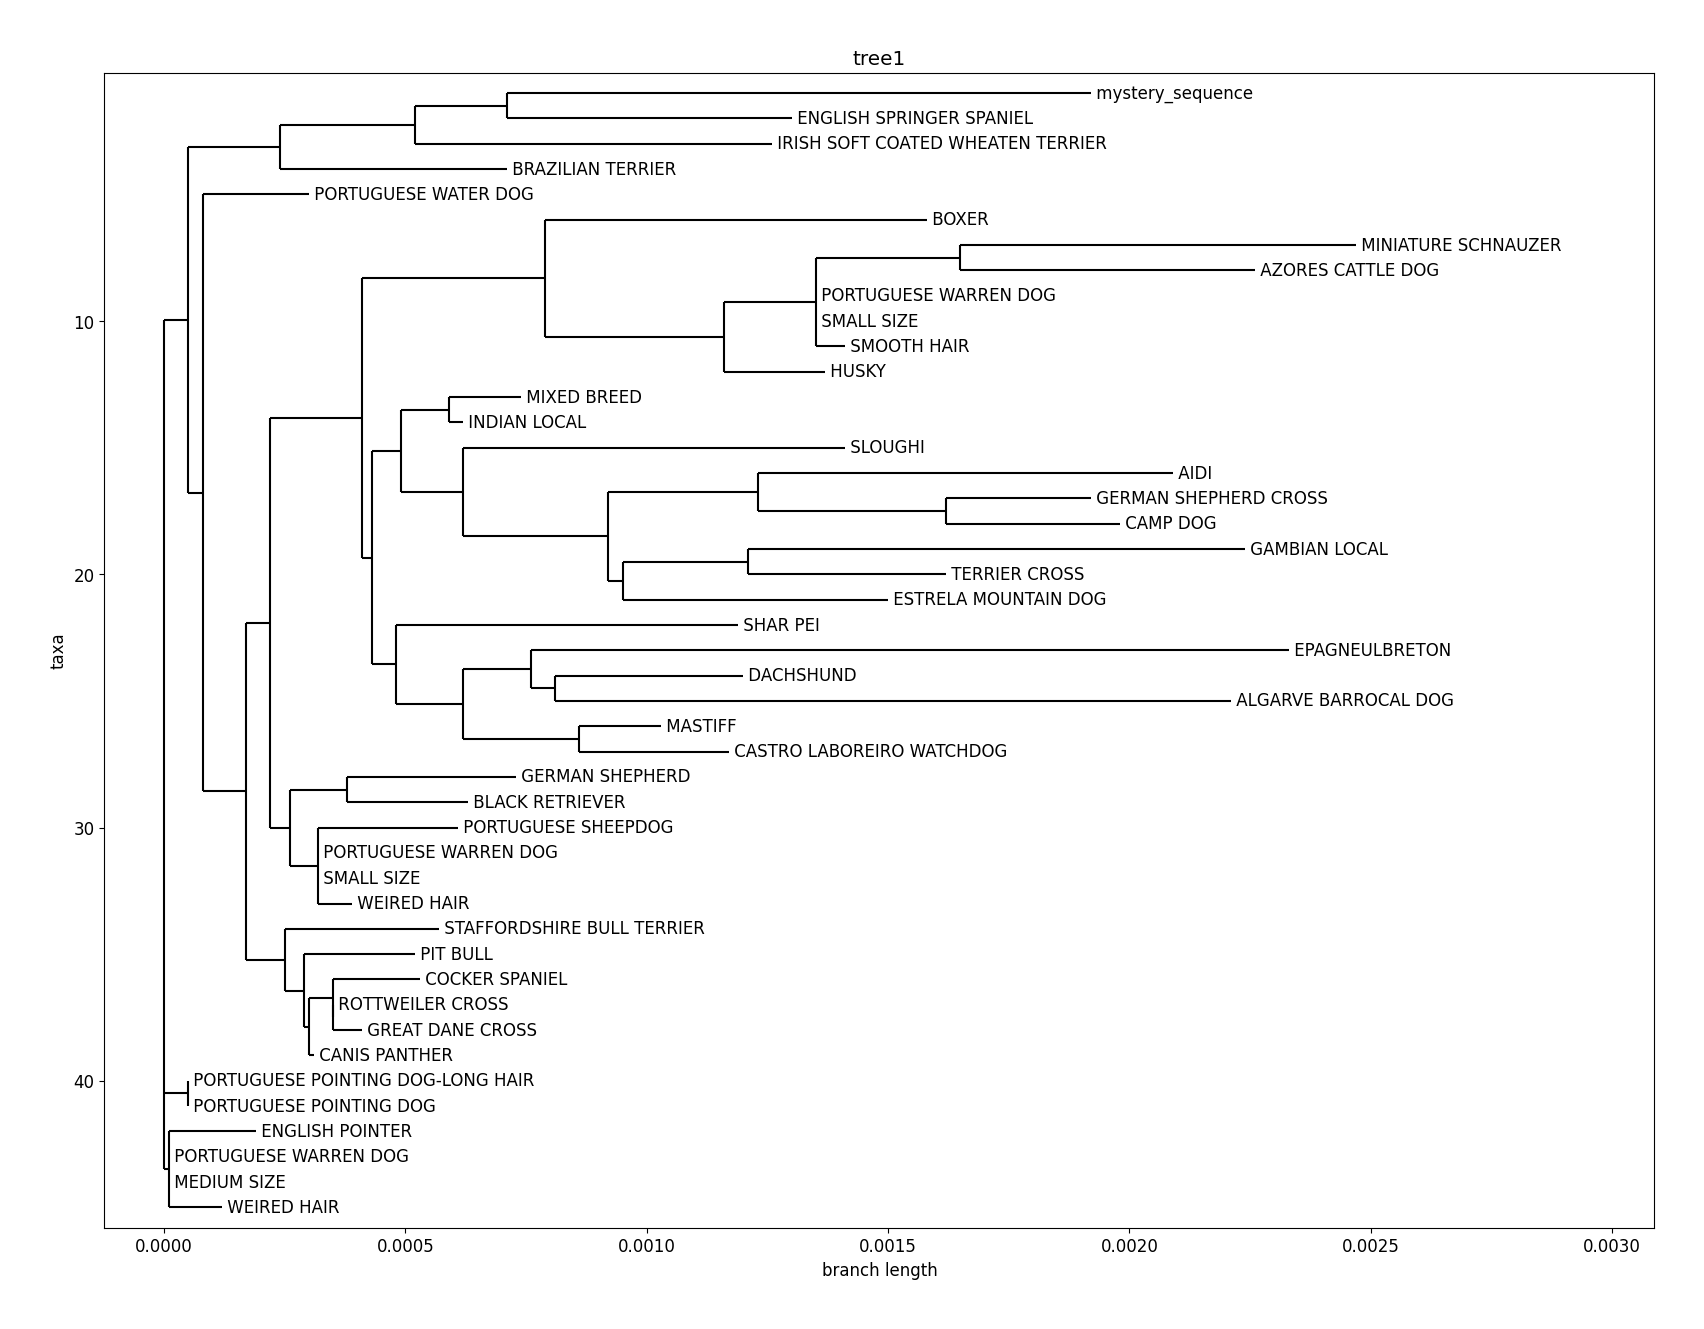

In [ ]:

consensus_sequences_with_unknown = add_mystery_to_consensus()

#create a multisequence alignment between unknownn dna and all consensus sequences
# Create a MultipleSeqAlignment object
MSA_alignment = Bio.Align.MultipleSeqAlignment(consensus_sequences_with_unknown)
#create a directory and filename for the MSA alignment
filename3 = f"{output}/MSA_alignment"  
#save the multiple sequence alignment in a clustal file 
AlignIO.write(MSA_alignment, filename3, "clustal")


# Calculate the distance matrix
calculator = DistanceCalculator("identity")
distance_matrix = calculator.get_distance(MSA_alignment)

# Build the tree using the neighbor-joining method
constructor = DistanceTreeConstructor(calculator, method="nj")
breeds_tree = constructor.build_tree(MSA_alignment)
# Save the tree to a new file 

Phylo.write(breeds_tree, "breeds_tree.xml", "phyloxml")
# Convert the tree to a different format (optional)
Phylo.convert("breeds_tree.xml", "phyloxml", "breeds_tree.nex", "nexus")

breeds_nex = Phylo.read("breeds_tree.nex", "nexus")
breeds_nex.rooted = True
# Create a custom label function that returns None for inner clade labels
def custom_label_func(node):
    if node.is_terminal():
        return (node.name).replace("'", "")
    else:
        return None
    
import matplotlib
fig = plt.figure(figsize=(20,15), dpi=100, frameon=False)
matplotlib.rc("font", size=12)
ax = plt.gca()
Phylo.draw(breeds_nex, show_confidence=True, axes=ax, label_func=custom_label_func)


#find regions of the most diversity 
#define diversity as more than 10 sequences differing in that region 

In [ ]:
#create a consensus sequence of all the dog breeds, which regions are essential to making a dog a dog?
dog_consensus = consensus_seq(dog_breeds)
#TASK TO DO = CREATE A FILE TO SAVE THIS INFO 

#create a list storing the level of conservation at each possition in the multiple sequence alignemnt 
def conseravtion_counter(consensus = dog_consensus, individuals = dog_breeds):
    """This function takes dog consensus_sequence and a list of individual dog DNA as fasta files to return the conservation of each sequence in comparasion to overall consensus as a matrix"""
    conservation = []
    aligner = Bio.Align.PairwiseAligner()
    for record in SeqIO.parse(individuals, "fasta"): 
        #create a temporary list to store the conservation detail of each individual alignment 
        temp = []
        alignment = aligner.align(record.seq, consensus.seq) 
        #itterate through every column of the alignment
        for a in range(len(alignment[0][0])): 
            #check if first and second sequence is the same at point a, a describing the column 
            if alignment[0][0,a] == alignment[0][1,a]: 
                temp.append(1)
            else:
                temp.append(0)
        conservation.append(temp)
    return conservation 

print(conseravtion_counter())

"""x = np.arange(len(conseravtion_counter()))

plt.bar(x, conservation)
plt.show()"""

In [ ]:
#make a plot to represent the conservation levels of the MSA

MSA_alignment = AlignIO.read(f"{output}/MSA_alignment", "clustal")  

l = len(MSA_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100, show_consensus=True)
mv.savefig(f"{output}/top_alignment_image")


Tests 

In [ ]:
tests = r"C:\Users\User\Downloads\Coursework-main\Coursework-main\my_project\tests"
import Main_code

def test_read_fasta():
    """check if all the breeds are capitalised"""
    assert isinstance(Breed, type)
    #print(type(Breed))
    #all_breeds = set(Breed.breed())
    #all_breeds_same_type = set((Breed.breed()).capitalize())
    #assert all_breeds == all_breeds_same_type

test_read_fasta()


def test_percentage_similarity():
    """check if an alignment of two identical sequences returns 100% similarity as expected"""
    identical_sequence_alignment = simple_alignment(mystery_sequence[0],mystery_sequence[0])[1]
    assert percentage_similarity(identical_sequence_alignment[0]) == 100

test_percentage_similarity()

#create a test txt
def test_create_output_txt():
    """use a test file with a known txt content to check if the expected content is written to the file"""
    test_content = "test"
    test_file =  f"{tests}/test_txt"
    test_output = create_output(test_content, test_file, "txt")
    with open(test_file) as f:
         read = f.readlines()
    assert read[0] == test_content
#create a test fasta

test_create_output_txt()

def test_unique_breeds():
    all_breeds = unique_breeds()
    assert "BOXER" in all_breeds

test_unique_breeds()

def test_breed_sequences():
    """check if an example file contains only one breed type in the name"""
    example_file = f"{ind_breeds}/BOXER"
    record_names = []
    for record in SeqIO.parse(example_file, "fasta"):
        record_names.append(record.name)
    assert len(set(record_names)) == 1

test_breed_sequences()

def test_consensus_seq():
    """check if a file containing multiple instances of the same sequence has a consensus_seq output exactly the same"""
    filename1 = f"{tests}/test_file.fasta"
    filename2 = f"{tests}/consensus_test_file.fasta"
    for record in SeqIO.parse(filename1, "fasta"):
        test_sequence = record.seq
    print(test_sequence)
    for record in SeqIO.parse((consensus_seq(filename2)), "fasta"):
        test_consensus =  record.seq
    print(test_consensus)
    assert test_sequence == test_consensus

test_consensus_seq()

def test_consensus_file():
    """checks if all breeds are present in consensus file"""
    all_breeds = unique_breeds()
    for breed in all_breeds:
        assert breed in consensus_file()

test_consensus_file()

def test_align_consensus():
    """test the alignment of two identical sequences returns the correct output"""
    for key in Breed.all_instnces:
        if key.breed == "BOXER":
            test_sequence = key.sequence
    sequences_list = test_sequence
    unknown_sequence = test_sequence
    correct_alignment = simple_alignment(sequences_list,unknown_sequence)
    alignment = (align_consensus(sequences_list, unknown_sequence))[1]
    breed = (align_consensus(sequences_list, unknown_sequence))[2]
    assert breed == "BOXER"
    assert alignment == correct_alignment

test_align_consensus()


def test_runtime():
    """check the program runs for less than 10 min in total"""
    start_time = time.time()
    Main_code()
    total_time = ("--- %s seconds ---" % (time.time() - start_time)) 
    assert total_time  < 10*60

[Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGC...TAA'), Seq('GTTAATGTAGCTTAATTAATAAAGCAAG

KeyboardInterrupt: 

Functions that might not be needed